## 🌳 Decision Trees

Decision trees are one type of machine learning models that operate by deriving decision rules from the training set and using them for prediction purposes. Let $A$, $B$ and $C$ be some categorical features in the dataset and $W$ and $Z$ be some continuous features and let lowercase letters represent possible values for them. In this case, a general decision rule can takes the form:

$$(A=a) ∧ (B=b) ∧ (C=c) ∧ (W>w) ∧ (Z>z) ⟹ [y=k] $$

Each path (and hence, leaf) in a decision tree corresponds to a rule like this. 

$\text{The training of the tree occurs as follow:}$

- Choose a feature (e.g., $A$ or $W$) and split it into ($A=a_1$, $A=a_2$, ..., $A=a_n$ or $W>w, W ≤ w$ )
   
    - Splitting means to add as child nodes (it's splitting in the sense that the training data will be distributed over them)

    - Multiple techniques were covered to choose the best feature

- For each of the $n$ splits (i.e., children), repeat the process with the remaining features (e.g., $B$, $C$, $W$ and $Z$)

- Stop when all instances are pure (i.e., all training points satisfying the conditions along the path from the root have the same label $y=k$) or when some other condition is met (e.g., to avoid overfitting).

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import randint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Plot import plot_model_contours

### 😎  We are Wearing our Machine Learning Engineer Spectacles Early This Time:

```python
TODO 1: Study the hyperparameters of the DecisionTreeClassifier as found in the documentation and answer the following:
```
1. Does increasing `min_samples_split` encourage a deeper or shallower tree and what effect does this have on overfitting?

In [ ]:
"""
Answer:

The hyperparameter is used to define the minimum number of samples to exist in each node to split
otherwise the node will be considered to be a leaf, and for increasing it we would encourage shallowing
our tree, hence it wouldn't learn from the data much, so we need to balance it that
it won't be too small that the tree would overfit the data, and not the way too much that it would
not benefit from its categorical data to learn more about it
"""

"\nAnswer:\n\nThe hyperparameter is used to define the minimum number of samples to exist in each node to split\notherwise the node will be considered to be a leaf, and for increasing it we would encourage shallowing\nour tree, hence it wouldn't learn from the data much, so we need to balance it that\nit won't be too small that the tree would overfit the data, and not the way too much that it would\nnot benefit from its categorical data to learn more about it\n"

2. Answer the same question for increasing `min_impurity_decrease` and relate it to an equation in the lecture:

    - $\text{Gain}(S, X) = H(S) - \sum_{v \in \text{Values}(X)} \frac{|S_v|}{|S|} H(S_v)$


In [ ]:
"""
Answer:

The 'min-impurity-decrease' is accompined for the minimum reduction of impurity for each node, 
and the importance of the hyperparameter is to avoid overfitting on noise especially for marginal splits, and that
to have more reasonable representation for the dataset and that not to be biased to the dominant
classes, as we need not to increase the hyperparameter's value not to encourage having a shallower
tree
"""

"\nAnswer:\n\nThe 'min-impurity-decrease' is accompined for the minimum reduction of impurity for each node, \nand the importance of the hyperparameter is to avoid overfitting on noise especially for marginal splits, and that\nto have more reasonable representation for the dataset and that not to be biased to the dominant\nclasses, as we need not to increase the hyperparameter's value not to encourage having a shallower\ntree\n"

3. Devise an example where `min_samples_split=a` and `min_samples_leaf=b` and a split on a node is prevented although it has number of samples `c` where `c>a`.

In [7]:
"""
Answer:

.
└── Target Tree/
    └── Parent-1 (20-Samples)/
        ├── Child-1 (14-Samples)
        └── Child-2 (6-Samples, c = 6 > a = 5)/
            ├── Child-3 (2-Samples < min-samples-leaf = 3)
            └── Child-4 (4-Samples)
"""

'\nAnswer:\n\n.\n└── Target Tree/\n    └── Parent-1 (20-Samples)/\n        ├── Child-1 (14-Samples)\n        └── Child-2 (6-Samples, c = 6 > a = 5)/\n            ├── Child-3 (2-Samples < min-samples-leaf = 3)\n            └── Child-4 (4-Samples)\n'

It's important to note that the decision tree will keep training (splitting nodes) until all leaves are pure, one of the three conditions above stops any further node from splitting or `max_depth` hyperparameter is reached.

### 🐧 Load Penguins Dataset

You've done this many time in the past. So let's get over it quick:

In [8]:
# read the dataset
df = pd.read_csv('penguins.csv')                    # has many features and three classes (Penguin type)

# drop unwanted columns for the purposes of this experiment
df = df.drop(['studyName', 'Sample Number', 'Date Egg', 'Comments', 'Island', 'Stage', 'Individual ID',
              'Clutch Completion', 'Sex', 'Region'], axis=1)
df = df.drop(['Culmen Depth (mm)', 'Flipper Length (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)'], axis=1)

# drop missing values
df = df.dropna()

# save for easier access later
df.to_csv('penguins-clean.csv', index=False)
df

,Species,Culmen Length (mm),Body Mass (g)
0,Adelie Penguin (Pygoscelis adeliae),39.1,3750.0
1,Adelie Penguin (Pygoscelis adeliae),39.5,3800.0
2,Adelie Penguin (Pygoscelis adeliae),40.3,3250.0
4,Adelie Penguin (Pygoscelis adeliae),36.7,3450.0
5,Adelie Penguin (Pygoscelis adeliae),39.3,3650.0
...,...,...,...
338,Gentoo penguin (Pygoscelis papua),47.2,4925.0
340,Gentoo penguin (Pygoscelis papua),46.8,4850.0
341,Gentoo penguin (Pygoscelis papua),50.4,5750.0
342,Gentoo penguin (Pygoscelis papua),45.2,5200.0


Extract `x_data` and `y_data`

In [9]:
x_data_pd, y_data_pd = df.drop(columns=['Species']), df['Species']          
x_data, y_data = x_data_pd.to_numpy(), y_data_pd.to_numpy()
y_data = LabelEncoder().fit_transform(y_data)                               # convert labels to integers

### 👀 Decision Trees in Action

Let's start by studying the performance of the decision tree on the Penguins dataset.

In [11]:
# Define a decision tree classifier with max_depth=3 and random_state=42
clf = DecisionTreeClassifier(max_depth=3, random_state=42)

# Study the performance with 5-fold cross-validation (return the mean accuracy)
acc = cross_val_score(clf, x_data, y_data, cv=5).mean()
round(acc, 3)

np.float64(0.909)

Let's see what did the decision tree have to go through to result in this. We will use the package `dtreeviz` to visualize it (which looks better and is more informative than the visualization provided by `Scikit-learn`)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

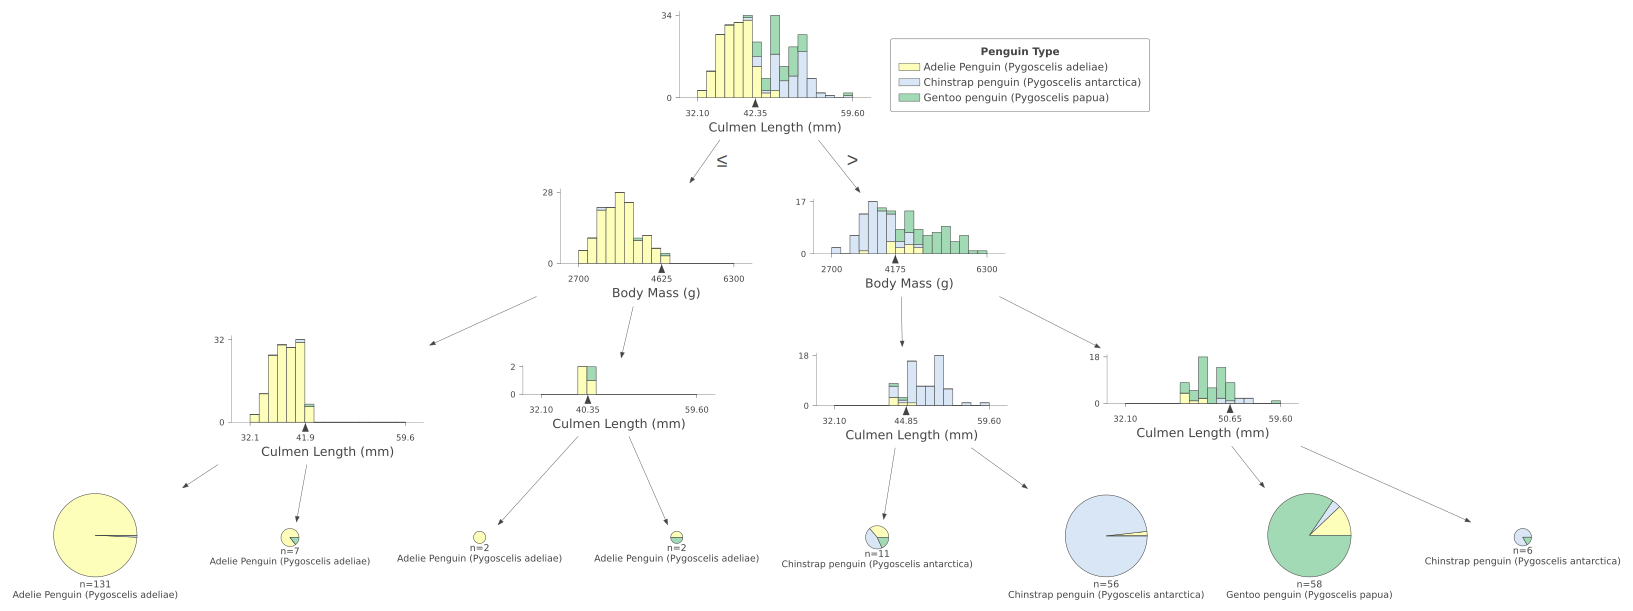

In [ ]:
import dtreeviz  # install me with pip install dtreeviz

# To simulate an arbitrary fold
m = x_data.shape[0]
x_train, y_train = x_data[: int(0.8 * m), :], y_data[: int(0.8 * m),]
clf.fit(x_train, y_train)


plt.style.use("default")
viz = dtreeviz.model(
    clf,
    x_train,
    y_train,
    target_name="Penguin Type",
    feature_names=x_data_pd.columns,
    class_names=np.unique(y_data_pd),
)

viz.view(scale=1.4)

```python
TODO 4: What do you think makes splitting at 4175 for the second node in the second level better than any other value? 
```

In [ ]:
"""
Answer:

As the histogram shows a big drop-off around 4000-4200 grams, for that the classifer evaluates
the suitable splitting points as 4175 grams.
"""

'\nAnswer:\n\nAs the histogram shows a big drop-off around 4000-4200 grams, for that the classifer evaluates\nthe suitable splitting points as 4175 grams\n'

```python
TODO 5: How many decision rules where found by this decision tree? Which three rules are the strongest and why?
```

In [ ]:
"""
Answer:

There are 8-decision rules, and the strongest rules are:
    1- The first rule contributing to the left-most path and this is logical since the biological trait of Adelie pinguins makes the rule meaningful in a real-world context
    
    2- The 6th rule, as it is reasonable since the Chinstrap penguin has intermediate features in the real-world
    
    3- The 7th rule, as it is reasonable since the Gentoo penguin has intermediate features in the real-world
"""

'\nAnswer:\n\nThere are 8-decision rules,\nThe strongest rules are:\n    1- The first rule contributing to the left-most path and this is logical since the biological trait of Adelie pinguins makes the rule meaningful in a real-world context\n    \n    2- The 6th rule, as it is reasonable since the Chinstrap penguin has intermediate features in the real-world\n    \n    3- The 7th rule, as it is reasonable since the Gentoo penguin has intermediate features in the real-world\n'

Now as we have seen, the 90% accuracy is not so satisfactory. Let's see if we can do better with hyperparameter search.

#### 🔍 Initialize Random Search

In [ ]:
# Define a DecisionTree classifier with random_state=42
clf = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter search distribution
param_dist = {
    "min_samples_split": randint(2, 51),  # 2 to 50
    "min_samples_leaf": randint(1, 21),  # 1 to 20
    "max_depth": list(range(5, 55, 5)),  # 5 to 50 with step of 5
    "min_impurity_decrease": list(
        np.linspace(0.0, 0.5, 20)
    ),  # Decide a reasonable range here (with 20 values)
}

#  Initialize the Random Search object with 200 iterations, 5-fold cross-validation and random_state=42
clf_searched = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=200,
    cv=5,
    random_state=42,
    n_jobs=1,
)

#### 🔍 Perform the Search

In [ ]:
# fit the wrapped model (i.e., search and set the best hyperparameters)
clf_searched.fit(x_data, y_data)

### let's look at the top scores and the used hyperparameters:
relevant_columns = [
    "param_min_samples_split",
    "param_min_samples_leaf",
    "param_max_depth",
    "param_min_impurity_decrease",
    "mean_test_score",
    "std_test_score",
    "rank_test_score",
]

cv_results_df = (
    pd.DataFrame(clf_searched.cv_results_)[relevant_columns]
    .round(decimals=3)
    .sort_values(by="rank_test_score")
)
# above we filtered the clf_searched.cv_results_ as it has other irrelevant columns then rounded all values in it and sorted by score

cv_results_df.head(10)

,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_min_impurity_decrease,mean_test_score,std_test_score,rank_test_score
140,14,3,35,0.000,0.921,0.017,1
1,24,19,40,0.158,0.915,0.030,2
3,31,12,15,0.026,0.915,0.030,2
2,25,8,40,0.079,0.915,0.030,2
11,29,20,50,0.026,0.915,0.030,2
9,5,18,45,0.158,0.915,0.030,2
29,40,14,5,0.105,0.915,0.030,2
4,13,1,30,0.026,0.915,0.030,2
27,36,1,40,0.053,0.915,0.030,2
26,45,3,35,0.105,0.915,0.030,2


As we can see, the best score is not that good. Let's plot to understand more:

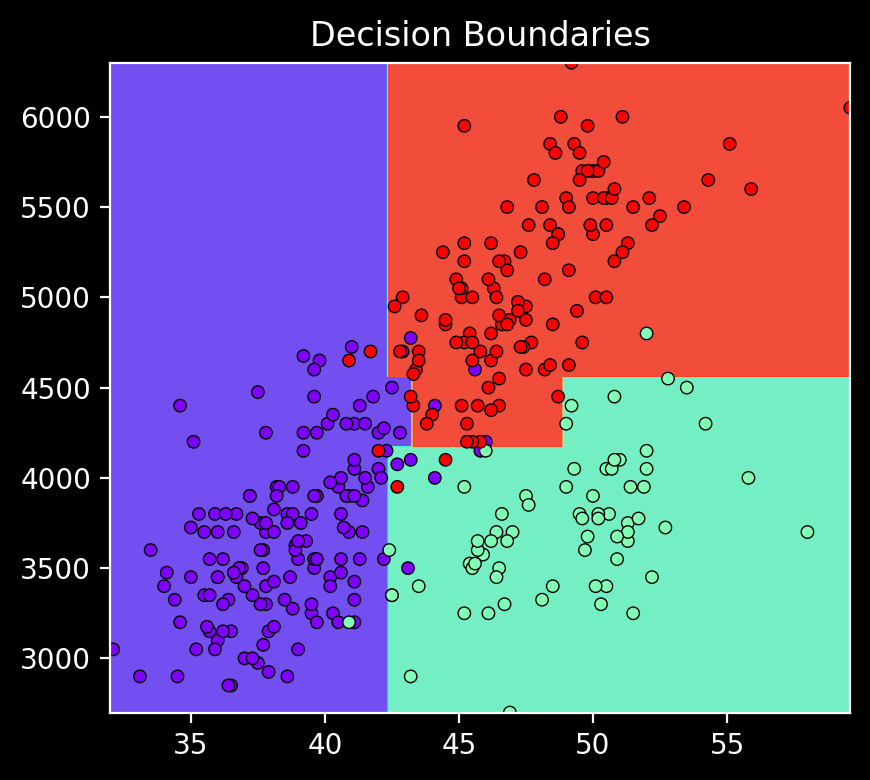

In [27]:
plot_model_contours(clf_searched,  x_data, y_data, trained=True)

```python
TODO 9: Given the plot, comment on what disadvantage of decision trees, as covered in the lecture, is most likely the reason for the mediocre performance. Comparing the boundary to the ideal decision boundary shall be helpful in this.
```

In [29]:
"""
Answer:

- greedy (may not find best tree)
- Only axis-aligned splits of data (continuous-data won't behave well)
"""

"\nAnswer:\n\n- greedy (may not find best tree)\n- Only axis-aligned splits of data (continuous-data won't behave well)\n"

### 🌀 Decision Trees and Overfitting:

Hyperparameters: 100%|██████████| 8/8 [00:12<00:00,  1.52s/it]


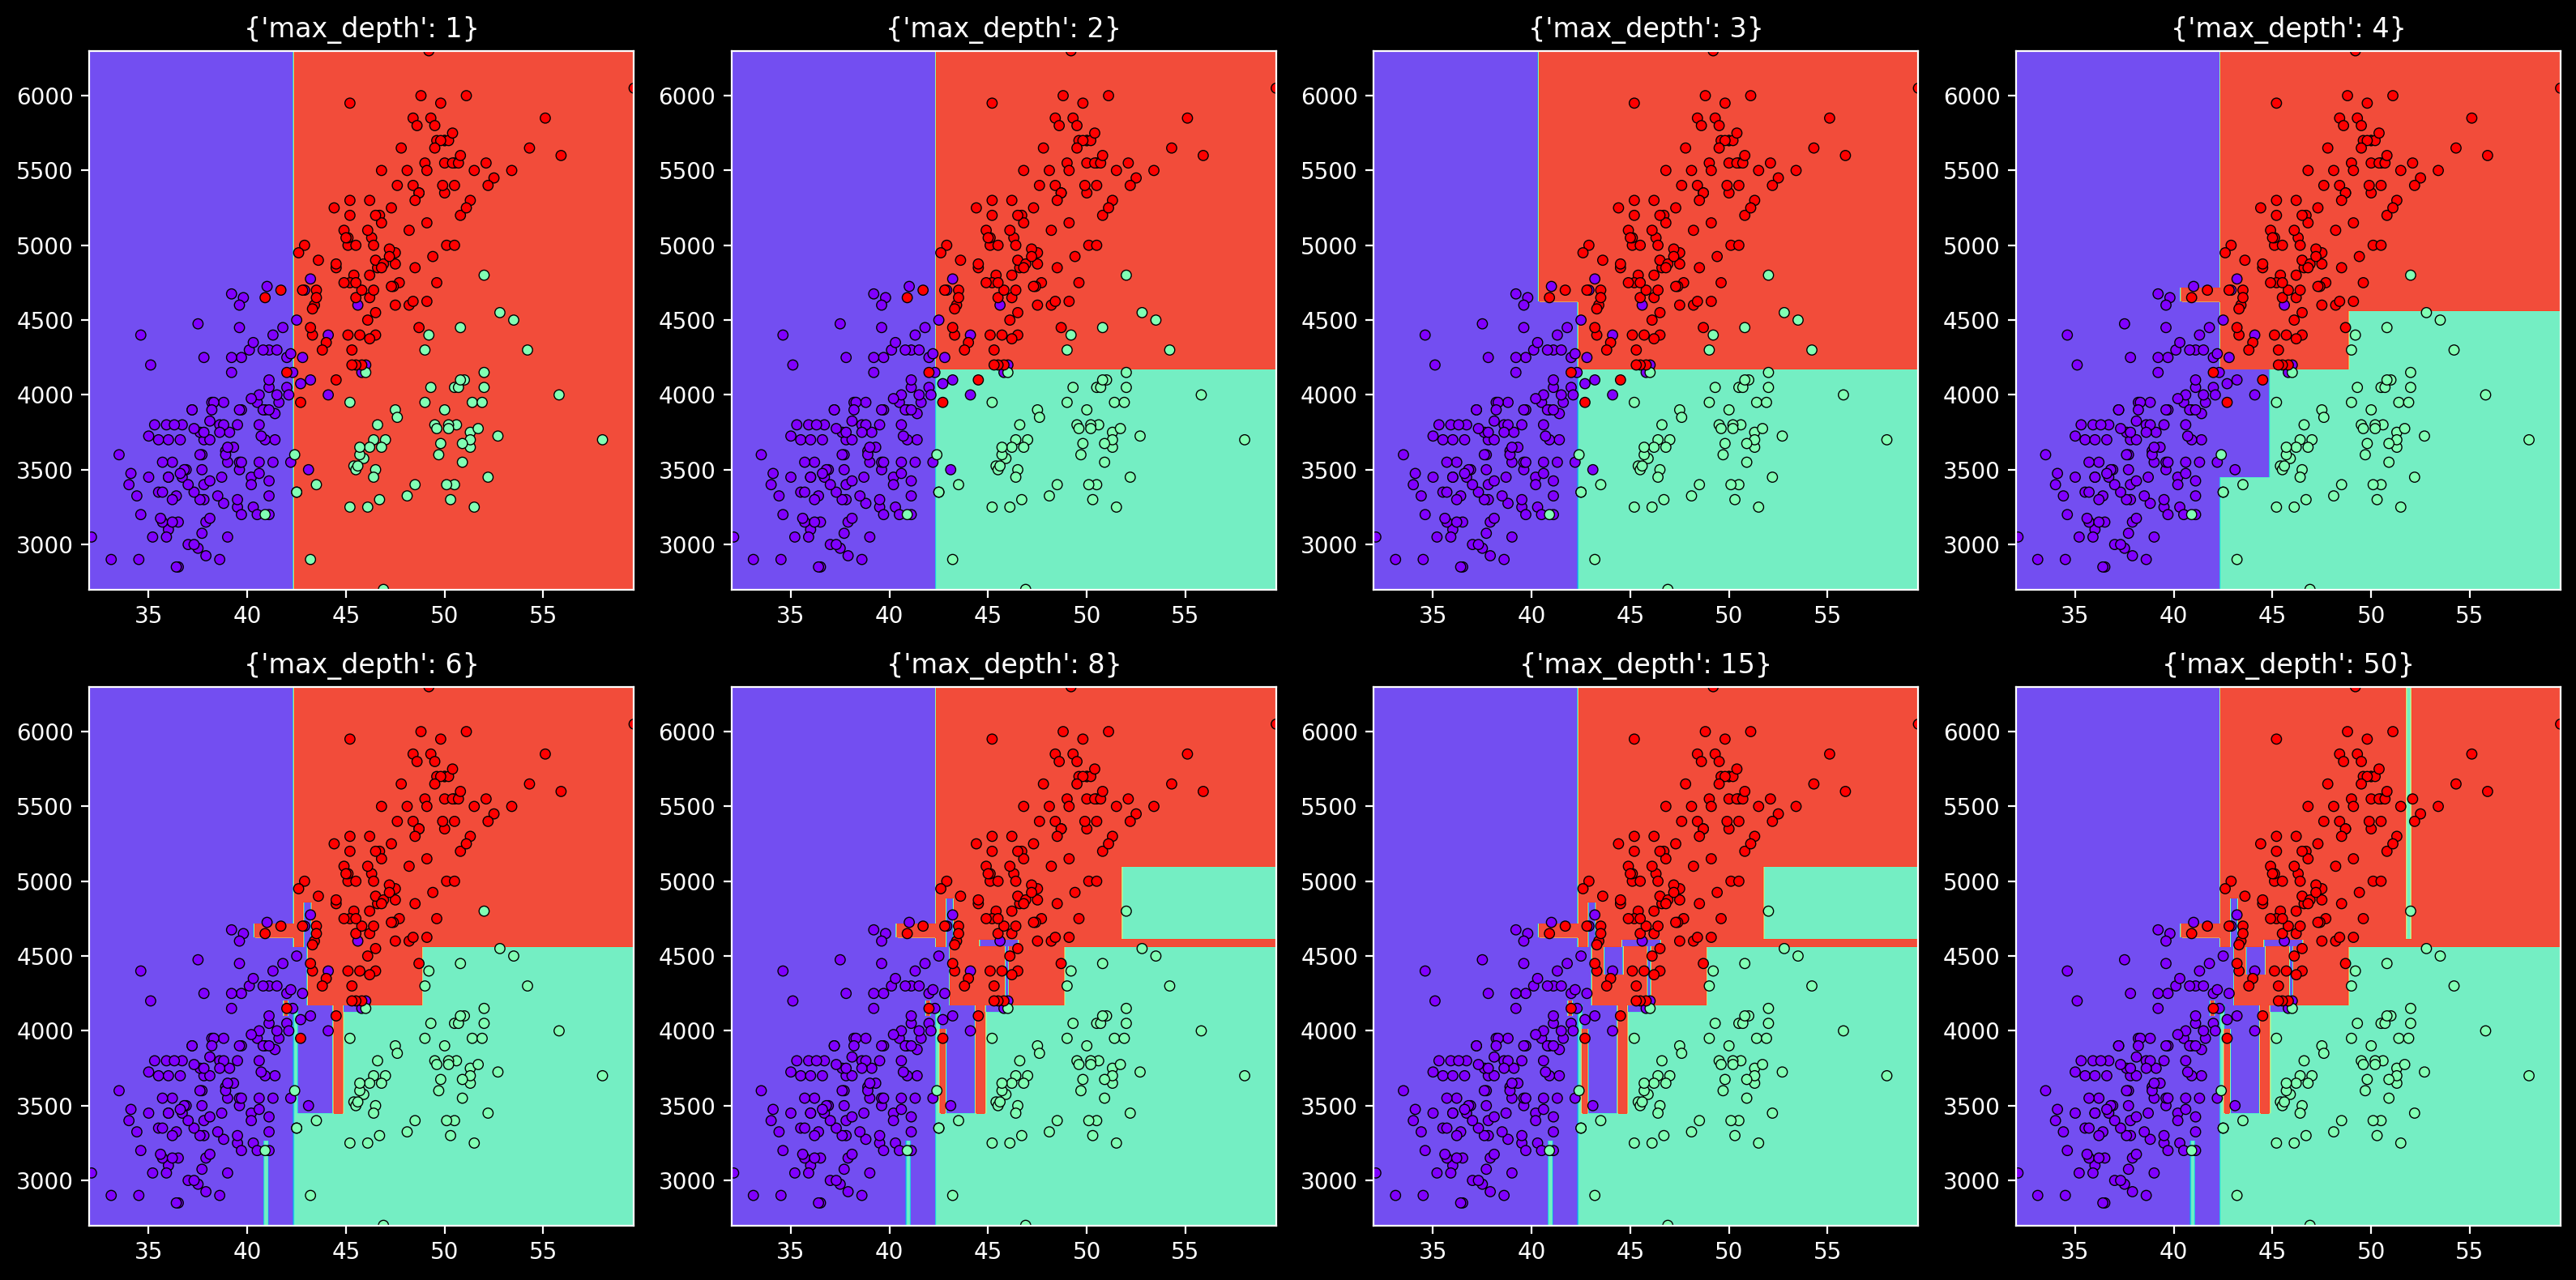

In [30]:
# Define the DecisionTreeClassifier model
dt_model = DecisionTreeClassifier()

# Use depth [1, 2, 3, 4, 6, 8, 15, 50]
hyperparams_list = [
    {"max_depth": 1},
    {"max_depth": 2},
    {"max_depth": 3},
    {"max_depth": 4},
    {"max_depth": 6},
    {"max_depth": 8},
    {"max_depth": 15},
    {"max_depth": 50},
]

# Plot decision boundaries.
plot_model_contours(dt_model, x_data, y_data, hyperparams_list=hyperparams_list)

```python
TODO 11: Given this, how does depth affect overfitting? Which depth seems the most optimal from the selection above?
```

In [31]:
'''
Answer:

I would interpret that the best depth is of 4, moreover the tree would overfit the data and that
we could recognize for depth > 4
'''

'\nAnswer:\n\nI would interpret that the best depth is of 4, moreover the tree would overfit the data and that\nwe could recognize for depth > 4\n'

####  🌀 Confirmatory Analysis for Overfitting

Hyperparameters: 100%|██████████| 8/8 [00:00<00:00, 115.42it/s]


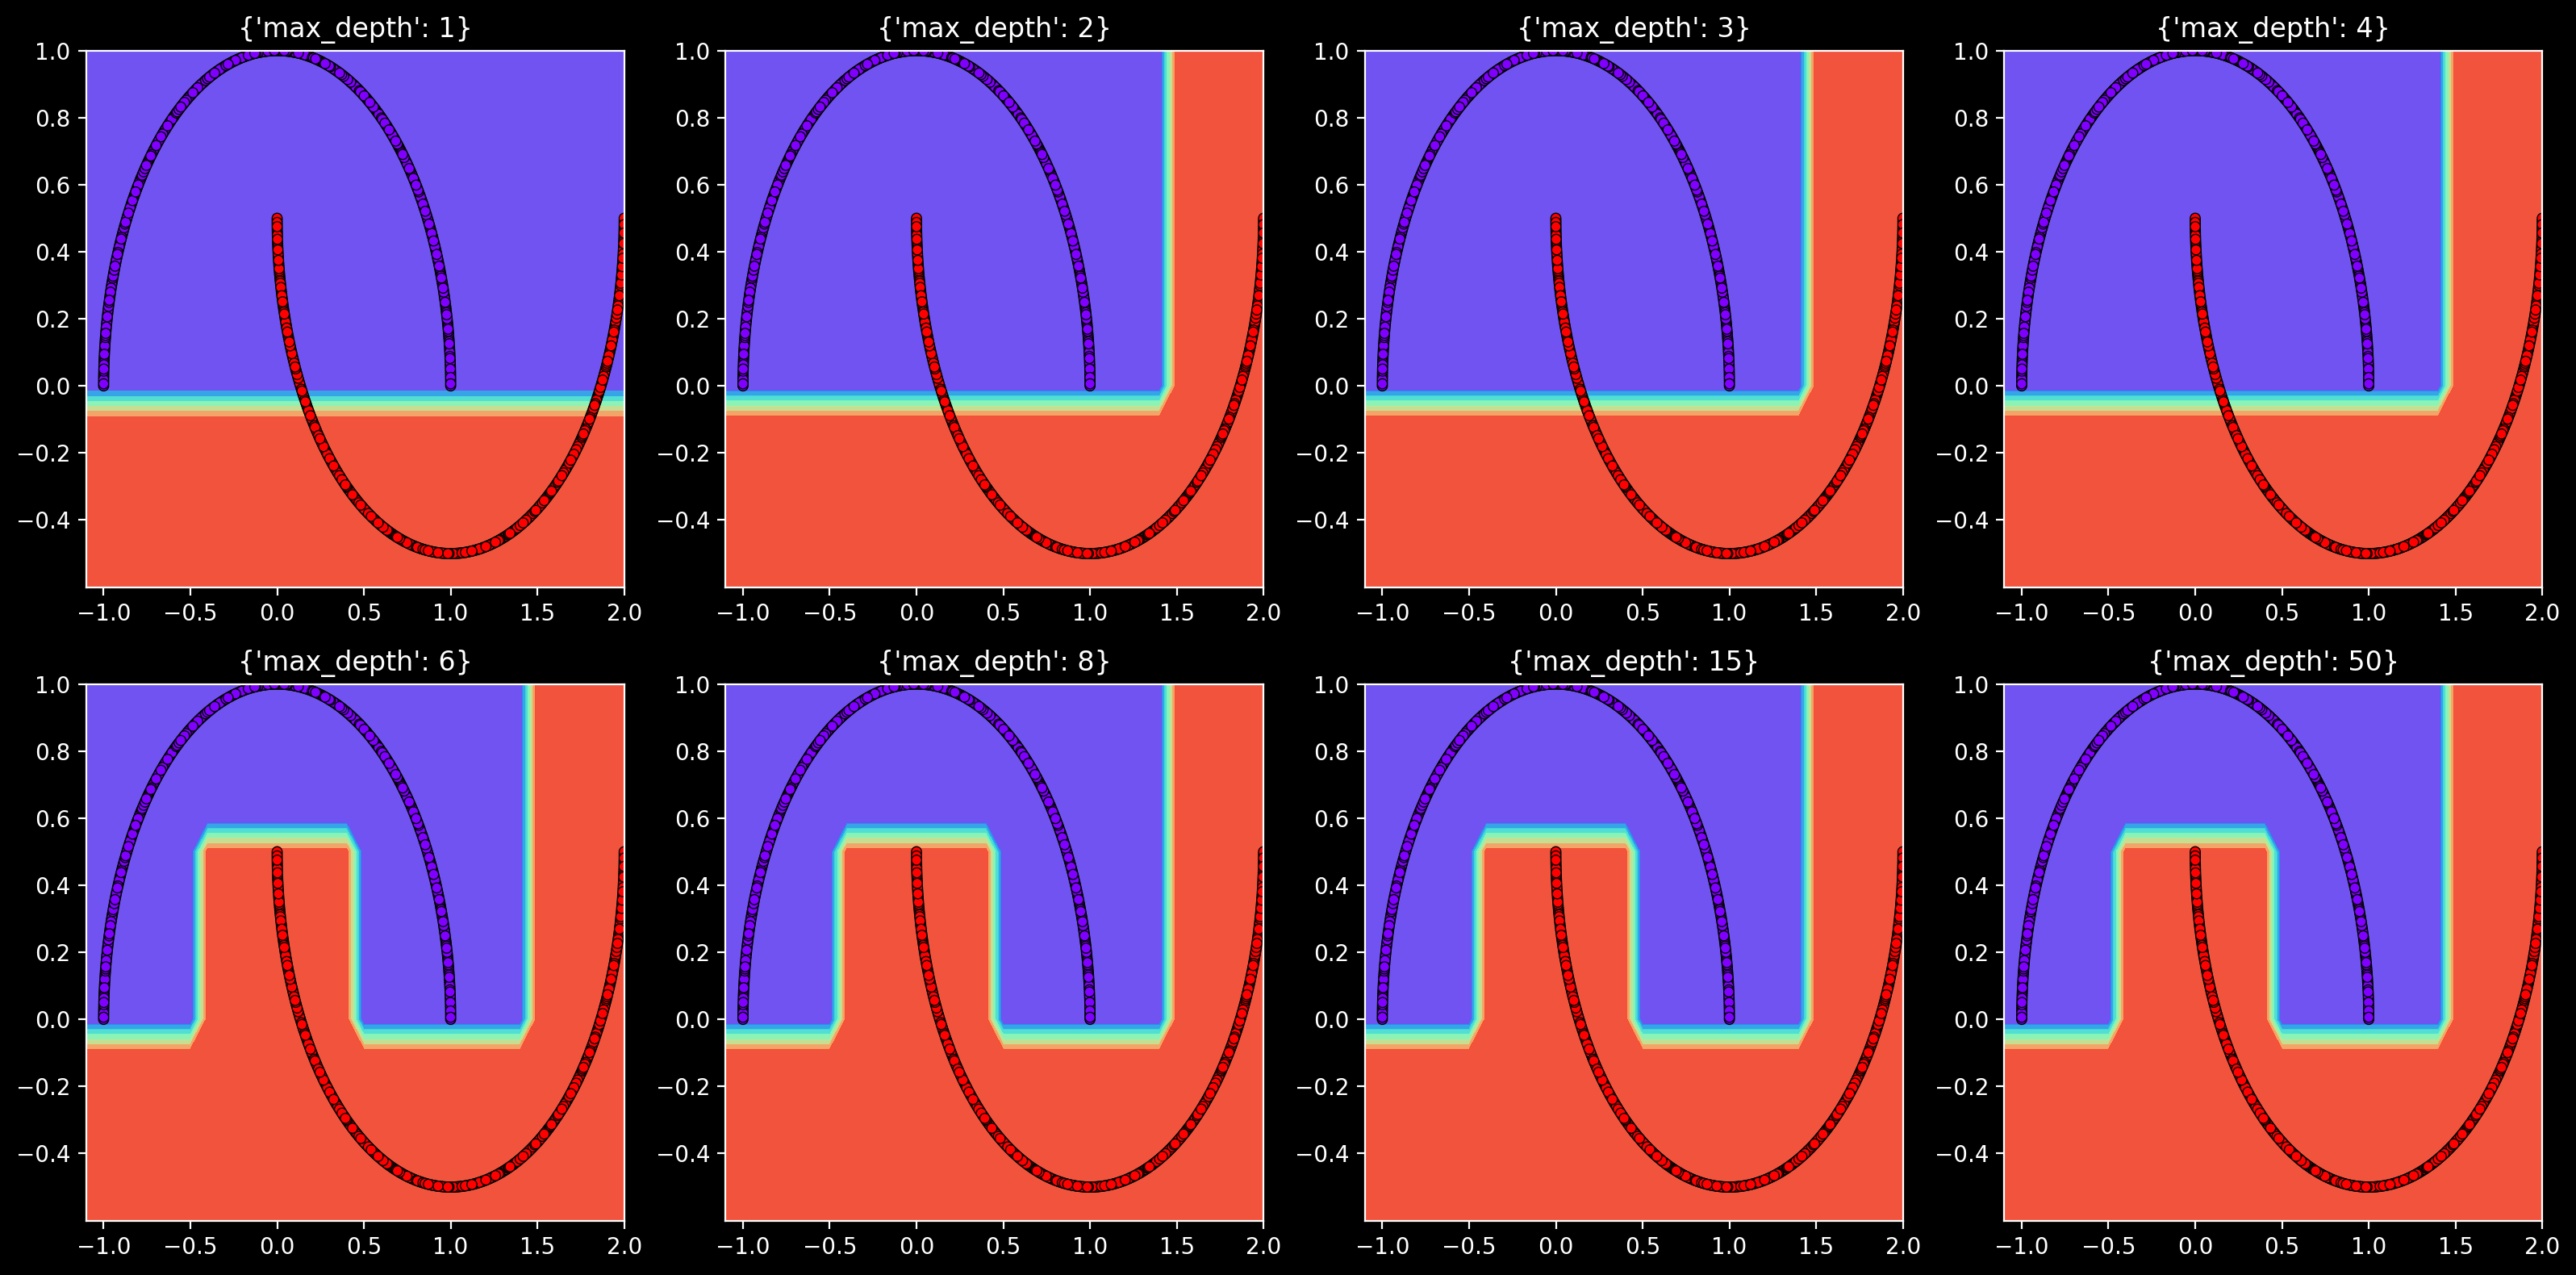

In [32]:
from sklearn.datasets import make_moons

# Call make_moons with n_samples=1000, noise=0.3 and random_state=42
x_data_m, y_data_m = make_moons(n_samples=1000, noise=0, random_state=42)
plot_model_contours(
    DecisionTreeClassifier(), x_data_m, y_data_m, hyperparams_list=hyperparams_list
)

<div align="center">
    <img src="https://i.imgur.com/LMiA2O5.gif" width=800/>
</div>